In [1]:
import os

In [2]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import keras


In [3]:
path = os.getcwd()
os.chdir(path)

In [4]:
df = pd.read_csv('/kaggle/input/indiaai/Train.csv')
df.head()

,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...


In [5]:
df1 = df[['crimeaditionalinfo','sub_category']].rename(columns={'crimeaditionalinfo':'data','sub_category':'labels'})
df1.head()

,data,labels
0,I had continue received random calls and abusi...,Cyber Bullying Stalking Sexting
1,The above fraudster is continuously messaging ...,Fraud CallVishing
2,He is acting like a police and demanding for m...,Online Gambling Betting
3,In apna Job I have applied for job interview f...,Online Job Fraud
4,I received a call from lady stating that she w...,Fraud CallVishing


In [6]:
df1['data'], df1['labels'] = df1['data'].astype(str) , df1['labels'].astype(str)

In [7]:
df1['labels'].unique().tolist()

['Cyber Bullying  Stalking  Sexting',
 'Fraud CallVishing',
 'Online Gambling  Betting',
 'Online Job Fraud',
 'UPI Related Frauds',
 'Internet Banking Related Fraud',
 'nan',
 'Other',
 'Profile Hacking Identity Theft',
 'DebitCredit Card FraudSim Swap Fraud',
 'EWallet Related Fraud',
 'Data Breach/Theft',
 'Cheating by Impersonation',
 'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks',
 'FakeImpersonating Profile',
 'Cryptocurrency Fraud',
 'Malware Attack',
 'Business Email CompromiseEmail Takeover',
 'Email Hacking',
 'Hacking/Defacement',
 'Unauthorised AccessData Breach',
 'SQL Injection',
 'Provocative Speech for unlawful acts',
 'Ransomware Attack',
 'Cyber Terrorism',
 'Tampering with computer source documents',
 'DematDepository Fraud',
 'Online Trafficking',
 'Online Matrimonial Fraud',
 'Website DefacementHacking',
 'Damage to computer computer systems etc',
 'Impersonating Email',
 'EMail Phishing',
 'Ransomware',
 'Intimidating Email',
 'Against Inte

In [8]:
df1['encoded_cat'] = df1['labels'].astype('category').cat.codes
df1.head()

,data,labels,encoded_cat
0,I had continue received random calls and abusi...,Cyber Bullying Stalking Sexting,4
1,The above fraudster is continuously messaging ...,Fraud CallVishing,15
2,He is acting like a police and demanding for m...,Online Gambling Betting,21
3,In apna Job I have applied for job interview f...,Online Job Fraud,22
4,I received a call from lady stating that she w...,Fraud CallVishing,15


In [9]:
df1.isnull().values.any()

False

In [10]:
data_texts = df1['data'].tolist()
data_labels = df1['encoded_cat'].tolist()

In [11]:
unique = df1['encoded_cat'].unique().tolist()
label_dict = {}
for i in unique:
  label_dict[i] = df1[df1['encoded_cat']==i]['labels'].unique()[0]
label_dict

{4: 'Cyber Bullying  Stalking  Sexting',
 15: 'Fraud CallVishing',
 21: 'Online Gambling  Betting',
 22: 'Online Job Fraud',
 32: 'UPI Related Frauds',
 18: 'Internet Banking Related Fraud',
 35: 'nan',
 25: 'Other',
 26: 'Profile Hacking Identity Theft',
 8: 'DebitCredit Card FraudSim Swap Fraud',
 12: 'EWallet Related Fraud',
 7: 'Data Breach/Theft',
 2: 'Cheating by Impersonation',
 10: 'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks',
 14: 'FakeImpersonating Profile',
 3: 'Cryptocurrency Fraud',
 20: 'Malware Attack',
 1: 'Business Email CompromiseEmail Takeover',
 13: 'Email Hacking',
 16: 'Hacking/Defacement',
 33: 'Unauthorised AccessData Breach',
 30: 'SQL Injection',
 27: 'Provocative Speech for unlawful acts',
 29: 'Ransomware Attack',
 5: 'Cyber Terrorism',
 31: 'Tampering with computer source documents',
 9: 'DematDepository Fraud',
 24: 'Online Trafficking',
 23: 'Online Matrimonial Fraud',
 34: 'Website DefacementHacking',
 6: 'Damage to computer com

In [12]:
! pip install scikit-learn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [13]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))


In [16]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=36)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=3,
          batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16),
         callbacks=[early_stopping])

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1730975018.823820      98 service.cc:145] XLA service 0x7c61195d3ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730975018.823878      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730975018.999511      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4638/4638 [==============================] - 2711s 573ms/step - loss: 1.4912 - accuracy: 0.5292 - val_loss: 1.3739 - val_accuracy: 0.5580
Epoch 2/3
4638/4638 [==============================] - 2648s 571ms/step - loss: 1.2956 - accuracy: 0.5821 - val_loss: 1.3737 - val_accuracy: 0.5698
Epoch 3/3
4638/4638 [==============================] - 2648s 571ms/step - loss: 1.1554 - accuracy: 0.6262 - val_loss: 1.4246 - val_accuracy: 0.5665


In [18]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  27684     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66981156 (255.51 MB)
Trainable params: 66981156 (255.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
from tensorflow.keras.models import load_model

In [22]:
save_directory = "first_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at first_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at first_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
predict_input = loaded_tokenizer.encode(test_t,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

prediction_label = label_dict[prediction_value]

print("🤖Predicted Sub_Category:", prediction_label)

🤖Predicted Sub_Category: Malware Attack


In [26]:
def predict_subcategory(text):

    predict_input = loaded_tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]

    return prediction_value
# -----------------------------------------------------
y_pred = []
for text_ in test_texts:
    y_pred.append(predict_subcategory(text_))

In [27]:
y_pred[10]

20

In [28]:
labels_sorted = dict(sorted(label_dict.items()))
labels_sorted

{0: 'Against Interest of sovereignty or integrity of India',
 1: 'Business Email CompromiseEmail Takeover',
 2: 'Cheating by Impersonation',
 3: 'Cryptocurrency Fraud',
 4: 'Cyber Bullying  Stalking  Sexting',
 5: 'Cyber Terrorism',
 6: 'Damage to computer computer systems etc',
 7: 'Data Breach/Theft',
 8: 'DebitCredit Card FraudSim Swap Fraud',
 9: 'DematDepository Fraud',
 10: 'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks',
 11: 'EMail Phishing',
 12: 'EWallet Related Fraud',
 13: 'Email Hacking',
 14: 'FakeImpersonating Profile',
 15: 'Fraud CallVishing',
 16: 'Hacking/Defacement',
 17: 'Impersonating Email',
 18: 'Internet Banking Related Fraud',
 19: 'Intimidating Email',
 20: 'Malware Attack',
 21: 'Online Gambling  Betting',
 22: 'Online Job Fraud',
 23: 'Online Matrimonial Fraud',
 24: 'Online Trafficking',
 25: 'Other',
 26: 'Profile Hacking Identity Theft',
 27: 'Provocative Speech for unlawful acts',
 28: 'Ransomware',
 29: 'Ransomware Attack',
 30: 

In [30]:
label_values = [*labels_sorted.values()]
label_values

['Against Interest of sovereignty or integrity of India',
 'Business Email CompromiseEmail Takeover',
 'Cheating by Impersonation',
 'Cryptocurrency Fraud',
 'Cyber Bullying  Stalking  Sexting',
 'Cyber Terrorism',
 'Damage to computer computer systems etc',
 'Data Breach/Theft',
 'DebitCredit Card FraudSim Swap Fraud',
 'DematDepository Fraud',
 'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks',
 'EMail Phishing',
 'EWallet Related Fraud',
 'Email Hacking',
 'FakeImpersonating Profile',
 'Fraud CallVishing',
 'Hacking/Defacement',
 'Impersonating Email',
 'Internet Banking Related Fraud',
 'Intimidating Email',
 'Malware Attack',
 'Online Gambling  Betting',
 'Online Job Fraud',
 'Online Matrimonial Fraud',
 'Online Trafficking',
 'Other',
 'Profile Hacking Identity Theft',
 'Provocative Speech for unlawful acts',
 'Ransomware',
 'Ransomware Attack',
 'SQL Injection',
 'Tampering with computer source documents',
 'UPI Related Frauds',
 'Unauthorised AccessData Bre

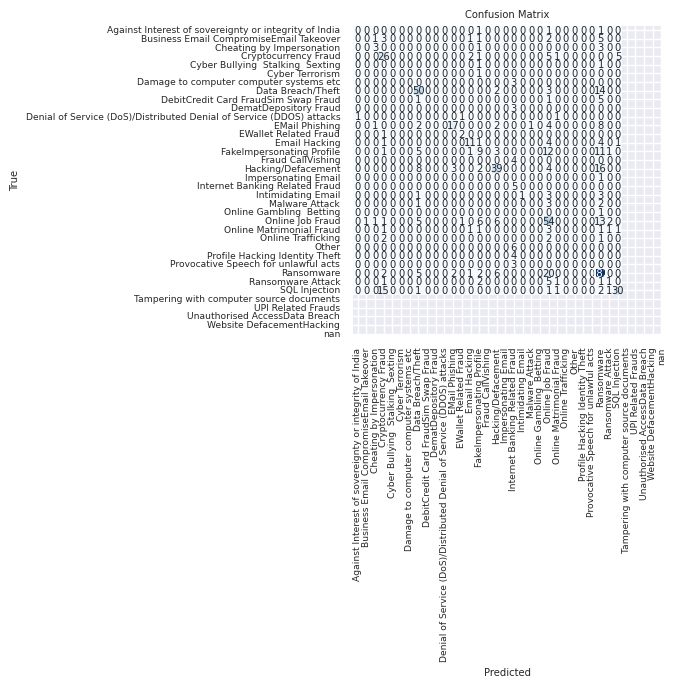

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

confusion = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 4))
sns.set(font_scale=0.6)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=label_values, yticklabels=label_values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        13
           3       0.50      0.43      0.46         7
           4       0.48      0.65      0.55        40
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.63      0.72      0.68        69
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.77      0.49      0.60        35
          13       0.50      0.67      0.57         3
          14       0.65      0.50      0.56        22
          15       0.31      0.21      0.25        43
          16       0.00      0.00      0.00         4
          18       0.67      0.54      0.60        72
          19       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
